<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/pyPARSER_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Conda Colab**

This cell must be always be run

In [1]:
#It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


install dependecies

In [2]:
%%capture
import sys
!pip -q install py3Dmol
!pip install git+https://github.com/pablo-arantes/biopandas
!mamba install openmmforcefields -c conda-forge -y
!git clone https://github.com/pablo-arantes/ProLIF.git
prolif1 = "cd /content/ProLIF"
prolif2 = "sed -i 's/mdanalysis.*/mdanalysis==2.0.0/' setup.cfg"
prolif3 = "pip install ."

original_stdout = sys.stdout # Save a reference to the original standard output

with open('prolif.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prolif1)
    print(prolif2)
    print(prolif3)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 prolif.sh 2>&1 1>/dev/null
!bash prolif.sh >/dev/null 2>&1
!mamba install -c conda-forge openbabel -y
!mamba install -c conda-forge ambertools -y
!mamba install -c conda-forge parmed -y
!pip install --upgrade MDAnalysis

#load dependencies
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
import parmed as pmd
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
!wget  https://raw.githubusercontent.com/openforcefield/openff-forcefields/master/openforcefields/offxml/openff_unconstrained-2.0.0.offxml

In [4]:
# Import Google Drive
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [3]:
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole
from openbabel import pybel

workDir = '/content/drive/MyDrive/MolecularDynamics_2023/USP/pyLiBELa/' 

Protein_PDB_file_name = 'MR.pdb'
Ligand_PDB_file_name = 'AS4.pdb'
Ligand_Protein_PDB_file_name = 'MR-AS4_leap.pdb'
Ligand_Protein_prmtop_file_name = 'MR-AS4.prmtop'
Ligand_Protein_inpcrd_file_name = 'MR-AS4.inpcrd'
Ligand_Protein_nc_file_name = 'prod.nc'


ligand_name = Ligand_PDB_file_name
file_name = os.path.join(workDir, str(Protein_PDB_file_name)) 
nc_name = os.path.join(workDir, str(Ligand_Protein_nc_file_name)) 
param_name = os.path.join(workDir, str(Ligand_Protein_prmtop_file_name)) 


#ligand_pdb = os.path.join(workDir, str(ligand_name))
#ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
#initial_pdb = os.path.join(workDir, "starting0.pdb")
#starting = os.path.join(workDir, "starting1.pdb")
#starting2 = os.path.join(workDir, "starting2.pdb")
#starting_end = os.path.join(workDir, "starting_end.pdb")

#  **Import pytraj package and trajectory file**

[pytraj.all_actions documentation](https://amber-md.github.io/pytraj/latest/_api/pytraj.all_actions.html)

In [22]:
import pytraj as pt

traj = pt.iterload(nc_name, param_name)
mask = ":AS4". #"@CA"
print(traj)

pytraj.TrajectoryIterator, 397 frames: 
Size: 0.436628 (GB)
<Topology: 49205 atoms, 15294 residues, 15038 mols, PBC with box type = orthorhombic>
           


In [23]:
%%time
#@title **Define Secondary Structure of Proteins**
residues, ss, _ = pt.dssp(traj, mask=mask)
dssp_all_atoms = pt.dssp_allatoms(traj, simplified=True)
dssp_all_residues = pt.dssp_allresidues(traj, simplified=True)

print(residues, ss)
print("/n")
print(dssp_all_atoms)
print("/n")
print(dssp_all_residues)

['AS4:1'] ['0' '0' '0' ... '0' '0' '0']
/n
[['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ...
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']]
/n
[['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ...
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']
 ['C' 'C' 'C' ... 'C' 'C' 'C']]
CPU times: user 1min 37s, sys: 597 ms, total: 1min 38s
Wall time: 1min 40s


Text(0.5, 0.98, 'Root Mean Square Deviation (RMS) :AS4')

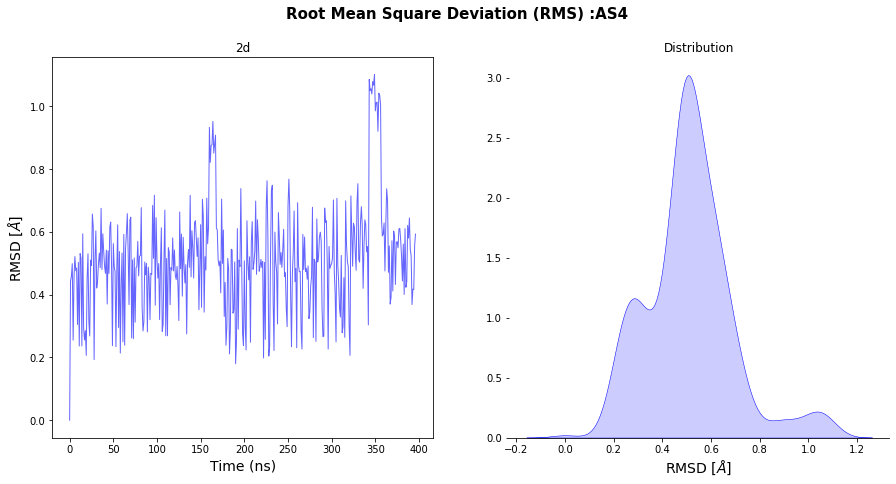

In [26]:
#@title **Compute RMSD**

Output_name = 'MR-AS4_rmsd_'+mask[1:]


rmsd = pt.rmsd(traj, ref=0, mask=mask)
data_rmsd_ref = pt.rmsd(traj, ref=0, mask=mask)

#Write_the_trajectory = 250000
#time = len(rmsd)*int(Write_the_trajectory)/1000
#time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
fig, axs = plt.subplots(1, 2, figsize=(15,7))

axs[0].plot(rmsd, alpha=0.6, color = 'blue', linewidth = 1.0) #time_array,
#plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

axs[0].set_xlabel("Time (ns)", fontsize = 14)#, fontweight = 'bold')
axs[0].set_ylabel("RMSD [$\AA$]", fontsize = 14)#, fontweight = 'bold')
#axs[0].set_xticks(fontsize = 12); axs[0].set_yticks(fontsize = 12);
#axs[0].tick_params(axis=u'both', which=u'both', length=6, width=2)
axs[0].set_title('2d')

sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5, ax=axs[1])
axs[1].set_xlabel('RMSD [$\AA$]', fontsize = 14)#, fontweight = 'bold')
axs[1].set_ylabel('')
axs[1].set_title('Distribution')
#axs[1].set_xticks(fontsize = 12) #axs[1].set_yticks(fontsize = 12)
#axs[1].tick_params(axis=u'both', which=u'both', length=6, width=2)

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(True)
axs[1].spines['left'].set_visible(False)

plt.suptitle("Root Mean Square Deviation (RMS) "+mask, fontsize=15, fontweight = 'bold')

#fig.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(rmsd)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
%%time
pt.pca(traj, mask=mask, n_vecs=2)

Text(0.5, 0.98, 'Radius of Gyration :AS4')

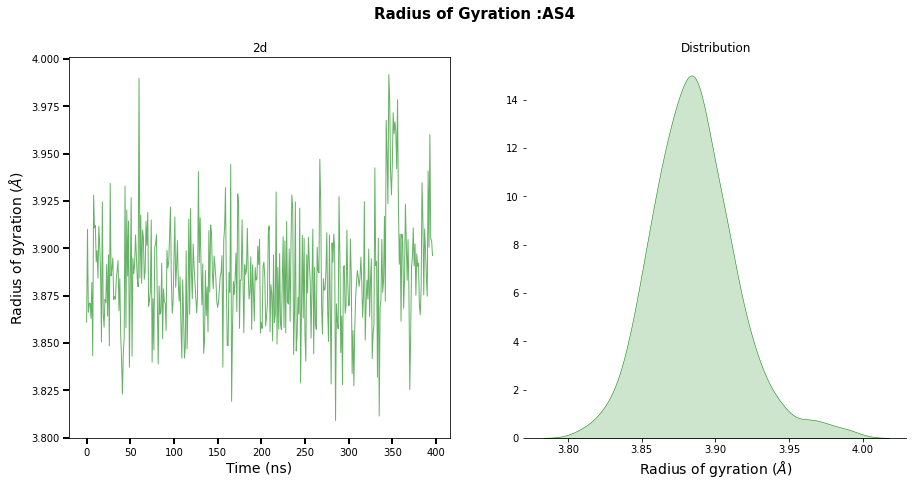

In [27]:
#@title **Compute radius of gyration**

Output_name = 'radius_gyration_'+mask[1:]

radgyr = pt.radgyr(traj, mask=mask)#, mask = "@CA")

fig, axs = plt.subplots(1, 2, figsize=(15,7))

axs[0].set_title('2d')
axs[0].plot(radgyr, alpha=0.6, color = 'green', linewidth = 1.0) # time_array,
#axs[0].set_xlim(0, simulation_ns); axs[0].set_ylim(2, 6)
axs[0].set_xlabel("Time (ns)", fontsize = 14)#, fontweight = 'bold')
axs[0].set_ylabel("Radius of gyration ($\AA$)", fontsize = 14)#, fontweight = 'bold')
axs[0].tick_params(axis=u'both', which=u'both', length=6, width=2)
#axs[0].set_xticks(fontsize = 12)
#axs[0].set_yticks(fontsize = 12)


axs[1].set_title('Distribution')
sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5, ax=axs[1])
axs[1].set_xlabel('Radius of gyration ($\AA$)', fontsize = 14)#, fontweight = 'bold')
#axs[1].set_xticks(fontsize = 12)
#axs[1].set_yticks([])
axs[1].set_ylabel('')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(True)
axs[1].spines['left'].set_visible(False)

plt.suptitle("Radius of Gyration "+mask, fontsize=15, fontweight = 'bold')
#fig.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(radgyr)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))


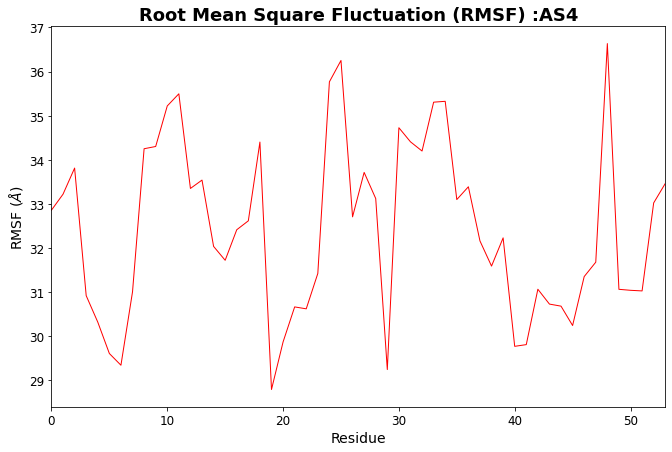

In [28]:
#@title **Compute RMSF**

Output_name = 'rmsf_'+mask[1:]

rmsf = pt.rmsf(traj, mask=mask)#, "mask=@CA")
bfactor = pt.bfactors(traj, byres=True)

plt.figure(figsize=(11,7))
plt.title('Root Mean Square Fluctuation (RMSF) '+mask, fontweight = 'bold', fontsize = 18)
plt.plot(rmsf[:,1], alpha=1.0, color = 'red', linewidth = 1.0)

plt.xlabel("Residue", fontsize = 14)#, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14)#, fontweight = 'bold')
plt.xticks(fontsize = 12);
plt.xlim(0, len(rmsf[:-1]))

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12);

#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(rmsf)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

CPU times: user 263 ms, sys: 82.8 ms, total: 345 ms
Wall time: 346 ms


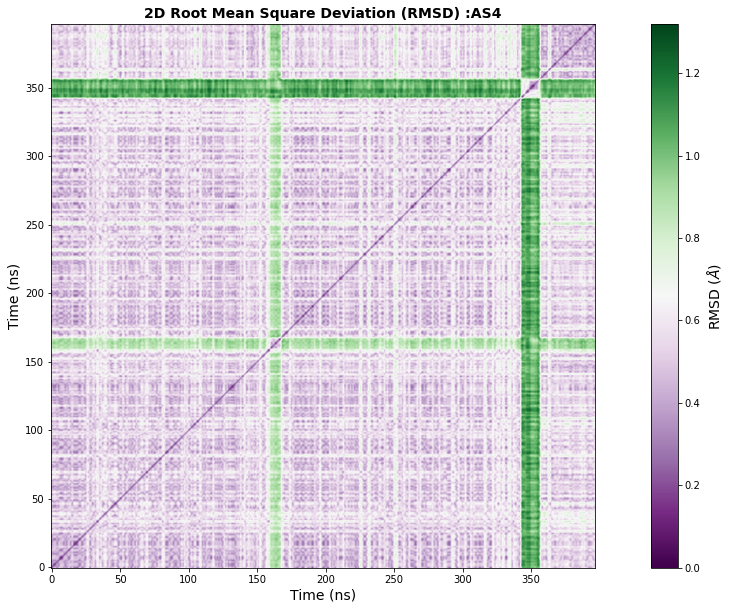

In [30]:
%%time
#@title **2D RMSD**

Output_name = '2D_rmsd_'+mask[1:]

#last_frame = len(time_array)
#stride_ticks_f = (last_frame)/5
#ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f)).astype(float)
#a = ticks_frame.astype(float)
#stride_ticks_t = (simulation_ns)/5
#tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t)).astype(float)
#b = tick_time.astype(float)

mat1 = pt.pairwise_rmsd(traj, mask=mask)#, frame_indices=range(int(number_frames_analysis)))

plt.figure(figsize = (20,10))
plt.imshow(mat1, cmap = 'PRGn', origin='lower', interpolation = 'bicubic')
plt.title('2D Root Mean Square Deviation (RMSD) '+mask, fontsize = 14, fontweight = 'bold')
plt.xlabel('Time (ns)', fontsize = 14)#, fontweight = 'bold')
plt.ylabel('Time (ns)', fontsize = 14)#, fontweight = 'bold')
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
#plt.xticks(ticks_frame, tick_time.round(decimals=3), fontsize = 12)
#plt.yticks(ticks_frame, tick_time.round(decimals=3), fontsize = 12)
# plt.xlim(0, a[-1]);  plt.ylim(0, a[-1])

cbar1 = plt.colorbar()
cbar1.set_label("RMSD ($\AA$)", fontsize = 14)#, fontweight = 'bold')


#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(mat1)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

In [ ]:
#@title **Calculate eigvenctors of Principle Component Analysis (PCA)**
data = pt.pca(traj_load, fit=True, ref=0, mask='@CA', n_vecs=2)
#print('projection values of each frame to first mode = {} \n'.format(data[0][0]))
#print('projection values of each frame to second mode = {} \n'.format(data[0][1]))
#print('eigvenvalues of first two modes', data[1][0])
#print("")
#print('eigvenvectors of first two modes: \n', data[1][1])

last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
a2 = a.tolist()
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

#@markdown **Provide output file names below:** 
Output_name = 'PCA' #@param {type:"string"}

Output_PC1 = 'PC1' #@param {type:"string"}
Output_PC2 = 'PC2' #@param {type:"string"}

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
projection_data = data[0]
plt.title(r'PCA of C-$\alpha$')
PC1 = data[0][0] 
PC2 = data[0][1]

a = plt.scatter(PC1,PC2, c=range(int(number_frames_analysis)), cmap='Greens', marker='o',s=8, alpha=1)
plt.clim(0, last_frame)

plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.ylabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# N = len(number_frames)
# x2 = np.arange(N)

cbar1 = plt.colorbar(a, orientation="vertical")
cbar1.set_label('Time(ns)', fontsize = 14, fontweight = 'bold')
cbar1.set_ticks(a2)
cbar1.set_ticklabels(b.round(decimals=3))

#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#pc1=pd.DataFrame(PC1)
#pc1.to_csv(os.path.join(workDir, Output_PC1 + ".csv"))
#pc2=pd.DataFrame(PC2)
#pc2.to_csv(os.path.join(workDir, Output_PC2 + ".csv"))

In [ ]:
#@title **Plot Principal Component 1 (PC1) and Principal Component 2 (PC2) as a ditribution**
Output_name = 'PCA_dist' #@param {type:"string"}


fig = plt.figure(figsize=(9,5))

plt.subplot(1, 2, 1)
ax = sb.kdeplot(PC1, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.subplot(1, 2, 2)
ax2 = sb.kdeplot(PC2, color="purple", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)


#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

In [ ]:
%%time
#@title **Pearson's Cross Correlation (CC)**

Output_name = 'cross_correlation_'+mask[1:] 

traj_align = pt.align(traj, ref=0, mask=mask) # , mask='@CA'
mat_cc = matrix.correl(traj_align, mask=mask)#, mask='@CA')

plt.title("Pearson's Cross Correlation (CC)", fontsize=18, fontweight=18)
ax = plt.imshow(mat_cc, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')

plt.xlabel('Residues', fontsize=14)#, fontweight = 'bold')
plt.ylabel('Residues', fontsize=14)#, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14)#, fontweight = 'bold')

#plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

#raw_data=pd.DataFrame(mat_cc)
#raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

# MD Analysis


Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of MD trajectories vary a lot and we do not intend to cover it all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations. 

Below, you can find a few examples of code snippets that can help you to shed some light on your simulation behavior.

In [ ]:
#@title **MM-PBSA method to calculate the binding free energy**
#@markdown **Important:** We will now calculate the interaction energy and solvation free energy for the complex, receptor and ligand and average the results to obtain an estimate of the binding free energy. Please note that we will not perform a calculation of the entropy contribution to binding and so strictly speaking our result will not be a true free energy but could be used to compare against similar systems. We will carry out the binding energy calculation using both the MM-GBSA method and the MM-PBSA method for comparison.

#@markdown Select the GB/SA input parameters,  the "OBC" models (igb=2 and 5) are newer, but appear to give significant improvements and are recommended for most projects (For more information check the Section 4.1 of the [Amber Manual](https://ambermd.org/doc12/Amber20.pdf)):
igb = "2" #@param ["1", "2", "5", "7", "8"]

if igb == "1":
  mbondi = 'mbondi'
elif igb == "2" or igb == "5":
  mbondi = 'mbondi2'
elif igb == "7":
  mbondi = 'bondi'
elif igb == "8":
  mbondi = 'mbondi3'
else:
  pass

Salt_concentration = '0.15' #@param {type:"string"}
fold_MMPBSA = "MMPBSA_igb_" + igb 
#@markdown **Provide output file names below:** 
Output_name = 'FINAL_RESULTS_MMPBSA' #@param {type:"string"}

final_mmpbsa = os.path.join(workDir, Output_name)

if number_frames_analysis > 10:
  stride = number_frames_analysis/10
else:
  stride = 1

f = open("mmpbsa.in", "w")
f.write("""&general """  + "\n"
"""  endframe=""" + str(int(number_frames_analysis)) + """,  interval=""" + str(int(stride)) + """, strip_mask=:WAT:Na+:Cl-:Mg+:K+, """ + "\n"
"""/ """ + "\n"
"""&gb """ + "\n"
""" igb=""" + str(igb) +  """, saltcon=""" + str(Salt_concentration) +  """, """ + "\n"
"""/ """ + "\n"
"""&pb """ + "\n"
""" istrng=""" + str(Salt_concentration) +  """, inp=2, radiopt=0, prbrad=1.4, """ + "\n"
"""/""")
f.close()

amberhome = "source /usr/local/amber.sh"
ante_MMPBSA = "ante-MMPBSA.py  -p " + str(pdb_ref) + " -c com.prmtop -r rec.prmtop -l ligand.prmtop -s :WAT:Na+:Cl-:Mg+:K+ -n :LIG --radii " + str(mbondi) 
MMPBSA = "MMPBSA.py -O -i mmpbsa.in -o " + str(final_mmpbsa) +  ".dat -sp " + str(pdb_ref) + " -cp com.prmtop -rp rec.prmtop -lp ligand.prmtop -y "  + str(traj)
mkdir = "mkdir " + os.path.join(workDir, fold_MMPBSA)
mv = "mv _MMPBSA* com.prmtop rec.prmtop ligand.prmtop reference.frc mmpbsa.in " + os.path.join(workDir, fold_MMPBSA)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_MMPBSA.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(amberhome)
    print(ante_MMPBSA)
    print(MMPBSA)
    print(mkdir)
    print(mv)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_MMPBSA.sh 2>&1 1>/dev/null
!bash run_MMPBSA.sh 2>&1 1>/dev/null

f_mmpbsa = open(final_mmpbsa + '.dat', 'r')
file_contents = f_mmpbsa.read()
print(file_contents)
f_mmpbsa.close()

<module 'pytraj' from '/usr/local/lib/python3.8/site-packages/pytraj/__init__.py'>

In [ ]:
#@title **Interaction Energy**
#@markdown **Important:** To quantify the strength of the interaction between the ligand and the protein, we will compute the nonbonded interaction energy between these two species.  It is important to note that this quantity is NOT a free energy or a binding energy. 

#@markdown **Provide output file names below:** 
Output_name = 'Interaction_energy' #@param {type:"string"}

pt_topology = traj_load.top
restraint_array = pt.select_atoms('!(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+) & !(:LIG)', pt_topology)
first_atom = restraint_array[0]
last_atom = restraint_array[-1]
mask = "LIE :LIG @" + str(first_atom+1) + "-" + str(last_atom+1)

lie = pt.analysis.energy_analysis.lie(traj_load, mask=mask, options='cutvdw 12.0 cutelec 12.0 diel 2.0', dtype='dict')

lie_elec = lie['LIE[EELEC]']
lie_vdw = lie['LIE[EVDW]']
lie_total = lie_elec + lie_vdw
lie_total_mean = mean(lie_total)
lie_total_stdev = stdev(lie_total)
print("Interaction Energy Average = " + str("{:.2f}".format(lie_total_mean)) + " \u00B1 " + str("{:.2f}".format(lie_total_stdev)) + " kcal/mol")

time = len(lie_total)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
ax = plt.plot(time_array, lie_total, alpha=0.6, color = 'blue', linewidth = 1.5, label= "Total Energy")
ax = plt.plot(time_array, lie_elec, alpha=0.6, color = 'green', linewidth = 1.5, label= "Electrostatic Energy")
ax = plt.plot(time_array, lie_vdw, alpha=0.6, color = 'red', linewidth = 1.5, label= "van der Waals Energy")

plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel('Interaction Energy \n (kcal/mol)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

lie_eelec = pd.DataFrame(lie['LIE[EELEC]'])
lie_eelec.to_csv(os.path.join(workDir, Output_name + "_eelec.csv"))
lie_evdw = pd.DataFrame(lie['LIE[EVDW]'])
lie_evdw.to_csv(os.path.join(workDir, Output_name + "_evdw.csv"))

# **LiBELa**

In [ ]:
!pip install git+https://github.com/pyparsing/pyparsing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyparsing/pyparsing to /tmp/pip-req-build-txzhrqic
  Running command git clone --filter=blob:none --quiet https://github.com/pyparsing/pyparsing /tmp/pip-req-build-txzhrqic
  Resolved https://github.com/pyparsing/pyparsing to commit 8e7ed8f2704f8d64bd79c1308c19d2b6fe0f781c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyparsing: filename=pyparsing-3.0.10-py3-none-any.whl size=102246 sha256=771b997a858f198a51aeb75e233e43de35aa1c5a980a05be49af83c93208bbec
  Stored in directory: /tmp/pip-ephem-wheel-cache-76dyzhjz/wheels/0d/d3/ff/5528e199378b7ee7a083f394f86303a6f07ff26b25ec1a19a6
Successfully built pyparsing
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled py

In [ ]:
! apt-get install libboost-python1.71-dev openbabel python-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python-dev-is-python2' instead of 'python-dev'
libboost-python1.71-dev is already the newest version (1.71.0-6ubuntu6).
libboost-python1.71-dev set to manually installed.
The following additional packages will be installed:
  libopenbabel6 libpython2-dev libpython2-stdlib libpython2.7 libpython2.7-dev
  libschroedinger-maeparser1 python-is-python2 python2 python2-dev
  python2-minimal python2.7-dev
Suggested packages:
  python2-doc python-tk
The following NEW packages will be installed:
  libopenbabel6 libpython2-dev libpython2-stdlib libpython2.7 libpython2.7-dev
  libschroedinger-maeparser1 openbabel python-dev-is-python2 python-is-python2
  python2 python2-dev python2-minimal python2.7-dev
0 upgraded, 13 newly installed, 0 to remove and 22 not upgraded.
Need to get 7,654 kB of archives.
After this operation, 35.9 MB of additional disk space will be used.
Get:1 http://arch

In [ ]:
! rm -f pyPARSER*
!wget https://raw.githubusercontent.com/alessandronascimento/pyLiBELa/main/src/pyPARSER.cpp
!wget https://raw.githubusercontent.com/alessandronascimento/pyLiBELa/main/src/pyPARSER.h
!g++ -Wall -Wextra -fPIC -shared -I/usr/include/python3.8 pyPARSER.cpp -o pyPARSER.so -L/usr/lib/x86_64-linux-gnu -lboost_python38
# warnings extra_warning optimizaiton public  library of files of cpp       linking code

--2023-02-28 15:32:47--  https://raw.githubusercontent.com/alessandronascimento/pyLiBELa/main/src/pyPARSER.cpp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22346 (22K) [text/plain]
Saving to: ‘pyPARSER.cpp’

pyPARSER.cpp        100%[===================>]  21.82K  --.-KB/s    in 0.002s  

2023-02-28 15:32:47 (12.5 MB/s) - ‘pyPARSER.cpp’ saved [22346/22346]

--2023-02-28 15:32:47--  https://raw.githubusercontent.com/alessandronascimento/pyLiBELa/main/src/pyPARSER.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12042 (12K) [text

In [ ]:
!ls

condacolab_install.log	openff_unconstrained-2.0.0.offxml  prolif.sh
drive			ProLIF				   sample_data
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyPARSER: filename=pyparser-1.0-py3-none-any.whl size=4921 sha256=4d025e9b622bb7c5d724d4b5fe04b365feb60c4c15e8e242b6fddeb909d197ba
  Stored in directory: /root/.cache/pip/wheels/d5/c1/97/c8d64328b6d76c0393314e67e06e366a75b7ffdf0406d2afc3
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18155 sha256=fa1e76cde17d567b61e237a229ca77289feacc114c9819c2b6433027c36b29a0
  Stored in directory: /root/.cache/pip/wheels/ec/be/db/6c913790b51ae090743152e15158ee7effdaefea9a940330e6
Successfully built pyPARSER parse


In [ ]:
#from pyPARSER import *
from pyparsing import *

Input = PARSER()

print(Input.temp)

NameError: ignored

In [ ]:
pyparsing.PARSER

NameError: ignored